In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import ktrain
from ktrain import graph as gr

Using TensorFlow backend.


using Keras version: 2.2.4


# Node Classification in Graphs


In this notebook, we will use *ktrain* to perform node classificaiton on the Cora citation graph. Each node represents a paper pertaining to one of several paper topics.  Links represent citations between papers.  The attributes or features assigned to each node are in the form of a multi-hot-encoded vector of words appearing in the paper.  The dataset is available [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The dataset is already in the form expected by *ktrain*, so let's begin.

### STEP 1: Load and Preprocess Data

We will hold out 10% of the nodes as a test set.  Since we set `holdout_for_inductive=False`, the nodes being heldout will remain in the graph, but only their features (not labels) will be visible to our model.  This is referred to as transductive inference.  Of the remaining nodes, 10% will be used for training and the remaining nodes will be used for validation (also transductive inference). As with the holdout nodes, the features (but not labels) of validation nodes will be available to the model during training. The return value `df_holdout` contain the features for the heldout nodes and `G_complete` is the original graph including the holdout nodes.  

In [3]:
(train_data, val_data, preproc, df_holdout, G_complete)  = gr.graph_nodes_from_csv(
                                                       'data/cora/cora.content', # node attributes/labels
                                                       'data/cora/cora.cites',                  # edge list
                                                       sample_size=20, 
                                                       holdout_pct=0.1, holdout_for_inductive=False,
                                                       train_pct=0.1, sep='\t')

Largest subgraph statistics: 2485 nodes, 5069 edges
Size of training graph: 2485 nodes
Training nodes: 223
Validation nodes: 2013
Nodes treated as unlabeled for testing/inference: 249
Holdout node features are visible during training (transductive inference)



The `preproc` object includes a reference to the training graph and a dataframe showing the features and target for each node in the graph (both training and validation nodes).

In [4]:
preproc.df.target.value_counts()

Neural_Networks           726
Genetic_Algorithms        406
Probabilistic_Methods     379
Theory                    344
Case_Based                285
Reinforcement_Learning    214
Rule_Learning             131
Name: target, dtype: int64

### STEP 2: Build a Model and Wrap in Learner Object

In [5]:
gr.print_node_classifiers()

graphsage: GraphSAGE:  http://arxiv.org/pdf/1607.01759.pdf


In [6]:
learner = ktrain.get_learner(model=gr.graph_node_classifier('graphsage', train_data, ), 
                             train_data=train_data, 
                             val_data=val_data, 
                             batch_size=64)

Is Multi-Label? False
done


### STEP 3:  Estimate LR 
Given the small number of batches per epoch, a larger number of epochs is required to estimate the learning rate. We will cap it at 100 here.

In [7]:
learner.lr_find(max_epochs=100)

simulating training for different learning rates... this may take a few moments...
Epoch 1/100
3/3 [==============================] - 1s 441ms/step - loss: 1.9648 - acc: 0.1302
Epoch 2/100
3/3 [==============================] - 0s 158ms/step - loss: 2.0053 - acc: 0.0873
Epoch 3/100
3/3 [==============================] - 1s 191ms/step - loss: 1.9632 - acc: 0.1510
Epoch 4/100
3/3 [==============================] - 0s 138ms/step - loss: 1.9682 - acc: 0.1411
Epoch 5/100
3/3 [==============================] - 1s 176ms/step - loss: 1.9776 - acc: 0.1304
Epoch 6/100
3/3 [==============================] - 0s 153ms/step - loss: 1.9632 - acc: 0.1536
Epoch 7/100
3/3 [==============================] - 1s 186ms/step - loss: 1.9682 - acc: 0.1562
Epoch 8/100
3/3 [==============================] - 0s 130ms/step - loss: 1.9509 - acc: 0.1275
Epoch 9/100
3/3 [==============================] - 1s 175ms/step - loss: 1.9662 - acc: 0.1137
Epoch 10/100
3/3 [==============================] - 1s 174ms/step - los

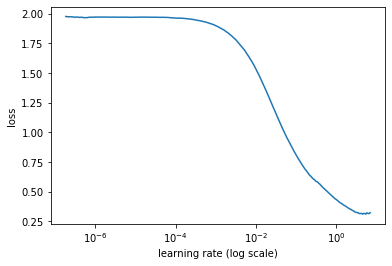

In [8]:
learner.lr_plot()

### STEP 4: Train the Model
We will train the model using `autofit`, which uses a triangular learning rate policy.  The training will automatically stop when the validation loss no longer improves. We save the weights of the model during training in case we would like to reload the weights from any epoch.

In [7]:
learner.autofit(0.01, checkpoint_folder='/tmp/saved_weights')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
4/4 [==============================] - 7s 2s/step - loss: 1.9479 - acc: 0.2029 - val_loss: 1.7514 - val_acc: 0.3060
Epoch 2/1024
4/4 [==============================] - 5s 1s/step - loss: 1.6925 - acc: 0.4066 - val_loss: 1.6553 - val_acc: 0.3492
Epoch 3/1024
4/4 [==============================] - 6s 1s/step - loss: 1.5708 - acc: 0.5345 - val_loss: 1.5262 - val_acc: 0.4898
Epoch 4/1024
4/4 [==============================] - 5s 1s/step - loss: 1.4280 - acc: 0.6994 - val_loss: 1.4030 - val_acc: 0.7074
Epoch 5/1024
4/4 [==============================] - 6s 1s/step - loss: 1.2972 - acc: 0.8828 - val_loss: 1.2960 - val_acc: 0.7765
Epoch 6/1024
4/4 [==============================] - 5s 1s/step - loss: 1.1721 - acc: 0.9143 - val_loss: 1.2132 - val_acc: 0.7879
Epoch 7/1024
4/4 [=========================

## Evaluate

#### Validate

In [8]:
learner.validate(class_names=preproc.get_classes())

                        precision    recall  f1-score   support

            Case_Based       0.73      0.81      0.77       227
    Genetic_Algorithms       0.90      0.96      0.93       331
       Neural_Networks       0.83      0.86      0.84       592
 Probabilistic_Methods       0.87      0.83      0.85       314
Reinforcement_Learning       0.80      0.75      0.77       170
         Rule_Learning       0.86      0.60      0.71       106
                Theory       0.73      0.70      0.72       273

              accuracy                           0.82      2013
             macro avg       0.82      0.79      0.80      2013
          weighted avg       0.82      0.82      0.82      2013



array([[183,   5,  11,   4,   6,   2,  16],
       [  1, 318,  10,   0,   1,   0,   1],
       [ 18,   5, 507,  25,  12,   1,  24],
       [  5,   0,  31, 262,   5,   0,  11],
       [  3,  16,  19,   1, 128,   0,   3],
       [ 21,   0,   4,   2,   0,  64,  15],
       [ 20,   9,  29,   8,   9,   7, 191]])

#### Create a Predictor Object

In [9]:
p = ktrain.get_predictor(learner.model, preproc)

#### Transductive Inference:  Making Predictions for Validation and Test Nodes in Original Training Graph
In transductive inference, we make predictions for unlabeled nodes whose features are visible during training. Making predictions on validation nodes in the training graph is transductive inference.

Let's see how well our prediction is for the first validation example.

In [12]:
p.predict_transductive(val_data.ids[0:1], return_proba=True)

array([[0.00738885, 0.00764509, 0.94959724, 0.00979447, 0.00634191,
        0.00760743, 0.01162501]], dtype=float32)

In [13]:
val_data[0][1][0]

array([0., 0., 1., 0., 0., 0., 0.])

Let's make predictions for all **test** nodes in the holdout set, measure test accuracy, and visually compare some of them with ground truth.

In [14]:
y_pred = p.predict_transductive(df_holdout.index, return_proba=False)

In [16]:
y_true = df_holdout.target.values

In [17]:
import pandas as pd
pd.DataFrame(zip(y_true, y_pred), columns=['Ground Truth', 'Predicted']).head()

,Ground Truth,Predicted
0,Theory,Theory
1,Genetic_Algorithms,Theory
2,Neural_Networks,Neural_Networks
3,Neural_Networks,Neural_Networks
4,Reinforcement_Learning,Reinforcement_Learning


In [18]:
import numpy as np
(y_true == np.array(y_pred)).mean()

0.8232931726907631

Our final test accuracy for transductive inference on the holdout nodes is **82.32%** accuracy.